# Significance Tests

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings

CURR_PATH = Path.cwd()
SEED = 59

warnings.filterwarnings('ignore')
font_family = "Calibri"

data_path = CURR_PATH.parents[0] / 'data'

In [2]:
styles = [
    dict(selector="th", props=[("font-size", "11pt"),
                               ("text-align", "center"),
                               ('font-family', font_family),
                               ('background-color', 'white'),
                               ('border-style', 'solid'),
                               ('border-color', 'grey'),
                               ('border-width', 'thin')]),
    dict(selector="td", props=[("font-size", "11pt"),
                               #("text-align", "center"),
                               ('font-family', font_family),
                               #('background-color', 'white'),
                               ('border-style', 'solid'),
                               ('border-color', 'grey'),
                               ('border-width', 'thin')]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

sns.set_theme(context='paper',  # notebook, paper, talk
              style='ticks', 
              font=font_family, 
              font_scale=2,
             )

## Dropout Prediction Data

In [3]:
pred_data = pd.read_csv(data_path / 'pred_data.csv' , sep=';')

print(pred_data.shape, pred_data['T'].unique())
pred_data.head()

(3300, 14) ['AN' 'AN1' 'AN2' 'AN3' 'AN4' 'GN']


,P,S,PS,ST,ST_Num,BAL,CO,DT,CLF,PR1,P1,T,PR2,P2
0,AR,2,AR2,G,0,S,0,0.35,RF,0.22,0,AN,0.32,0
1,AR,2,AR2,D,1,S,0,0.35,RF,0.12,0,AN,0.09,0
2,AR,2,AR2,G,0,S,0,0.35,RF,0.04,0,AN,0.04,0
3,AR,2,AR2,G,0,S,0,0.35,RF,0.06,0,AN,0.06,0
4,AR,2,AR2,G,0,S,0,0.35,RF,0.16,0,AN,0.02,0


## Recommendations Data

In [4]:
recoms = pd.read_csv(data_path / 'recom_data.csv', sep=';')

set_cols = [
    'Passed_Past', 'Passed_Next', 
    'ID_TO', 'D_List', 'Count_Next_TO',
    'Nbrs_Passed_Next_TO', 'AC', 'No_Recom_Rule', 'R', 'C', 'M', 'W', 'NoR',
    'NR'
]

for c in set_cols:
    recoms[c] = recoms[c].replace('set()',
                                  '{}').replace('None',
                                                '{}').apply(literal_eval)

TYPES = recoms['T'].unique()

print(recoms.shape, TYPES)
recoms.sample(n=5, random_state=SEED)

(16392, 64) ['AN' 'AN1' 'AN2' 'AN3' 'AN4' 'GN']


,P,ID,ST,#E_1,#E_2,#E_3,#F_1,#F_2,#F_3,#NE_1,...,ACC,REC_1,REC_0,BACC,PREC_1,F1,MCC,NT,MPT,PS
8464,CM,1974,G,5.0,6.0,6.0,0.0,0.0,0.0,0.0,...,1.000000,1.0,0.0,0.5,1.000000,1.0,0.0,AN,P4,CM2
7264,CM,421,D,5.0,5.0,7.0,1.0,0.0,2.0,0.0,...,1.000000,1.0,0.0,0.5,1.000000,1.0,0.0,AN,P4,CM2
9111,CM,2788,D,5.0,6.0,6.0,0.0,1.0,2.0,0.0,...,0.666667,0.8,0.0,0.4,0.800000,0.8,-0.2,AN,P3,CM2
1898,AR,1937,G,5.0,6.0,6.0,0.0,0.0,0.0,0.0,...,0.666667,1.0,0.0,0.5,0.666667,0.8,0.0,AN,P2,AR2
1373,AR,1477,G,5.0,6.0,6.0,0.0,0.0,1.0,0.0,...,1.000000,1.0,0.0,0.5,1.000000,1.0,0.0,GN,P0,AR2


In [5]:
to_compare = [('GN', val) for val in [t for t in TYPES if t != 'GN']]
print('to compare:', to_compare)

to compare: [('GN', 'AN'), ('GN', 'AN1'), ('GN', 'AN2'), ('GN', 'AN3'), ('GN', 'AN4')]


## Tests

### def test_stat_sign()

In [6]:
def test_stat_sign(df, to_test):

    p_vals = []

    for comp in to_compare:

        for ps in df['PS'].unique():

            for st in df['ST'].unique():

                data = df[(df['PS'] == ps) & (df['ST'] == st)]

                res = stats.wilcoxon(data[data['T'] == comp[0]][to_test],
                                     data[data['T'] == comp[1]][to_test],
                                     alternative='two-sided',
                                    #zero_method='zsplit'
                                    )
                stat = res[0]
                p_v = res[1]

                p_vals.append([comp[1], ps, st, round(p_v, 5)])

            
    p_vals = pd.DataFrame(p_vals, columns=['T', 'PS', 'ST', 'P_Values'])\
        .pivot_table(index=['T', 'PS'], columns='ST', values='P_Values')

    p_vals['Count'] = (p_vals > 0.05).sum(axis=1)
    p_vals.columns = pd.MultiIndex.from_product([[to_test], p_vals.columns])

    return p_vals

### Dropout Pred

In [7]:
to_test = 'PR2'

# just for the plot
pred_data['PR2_binned'] = pd.cut(pred_data['PR2'], 10) 
pred_data[['PR2','PR2_binned']].sample(n=5,random_state=SEED)

,PR2,PR2_binned
3092,0.83000,"(0.8, 0.9]"
2665,0.19357,"(0.1, 0.2]"
2971,0.21000,"(0.2, 0.3]"
2565,0.02000,"(-0.001, 0.1]"
3152,0.02000,"(-0.001, 0.1]"


#### Normality

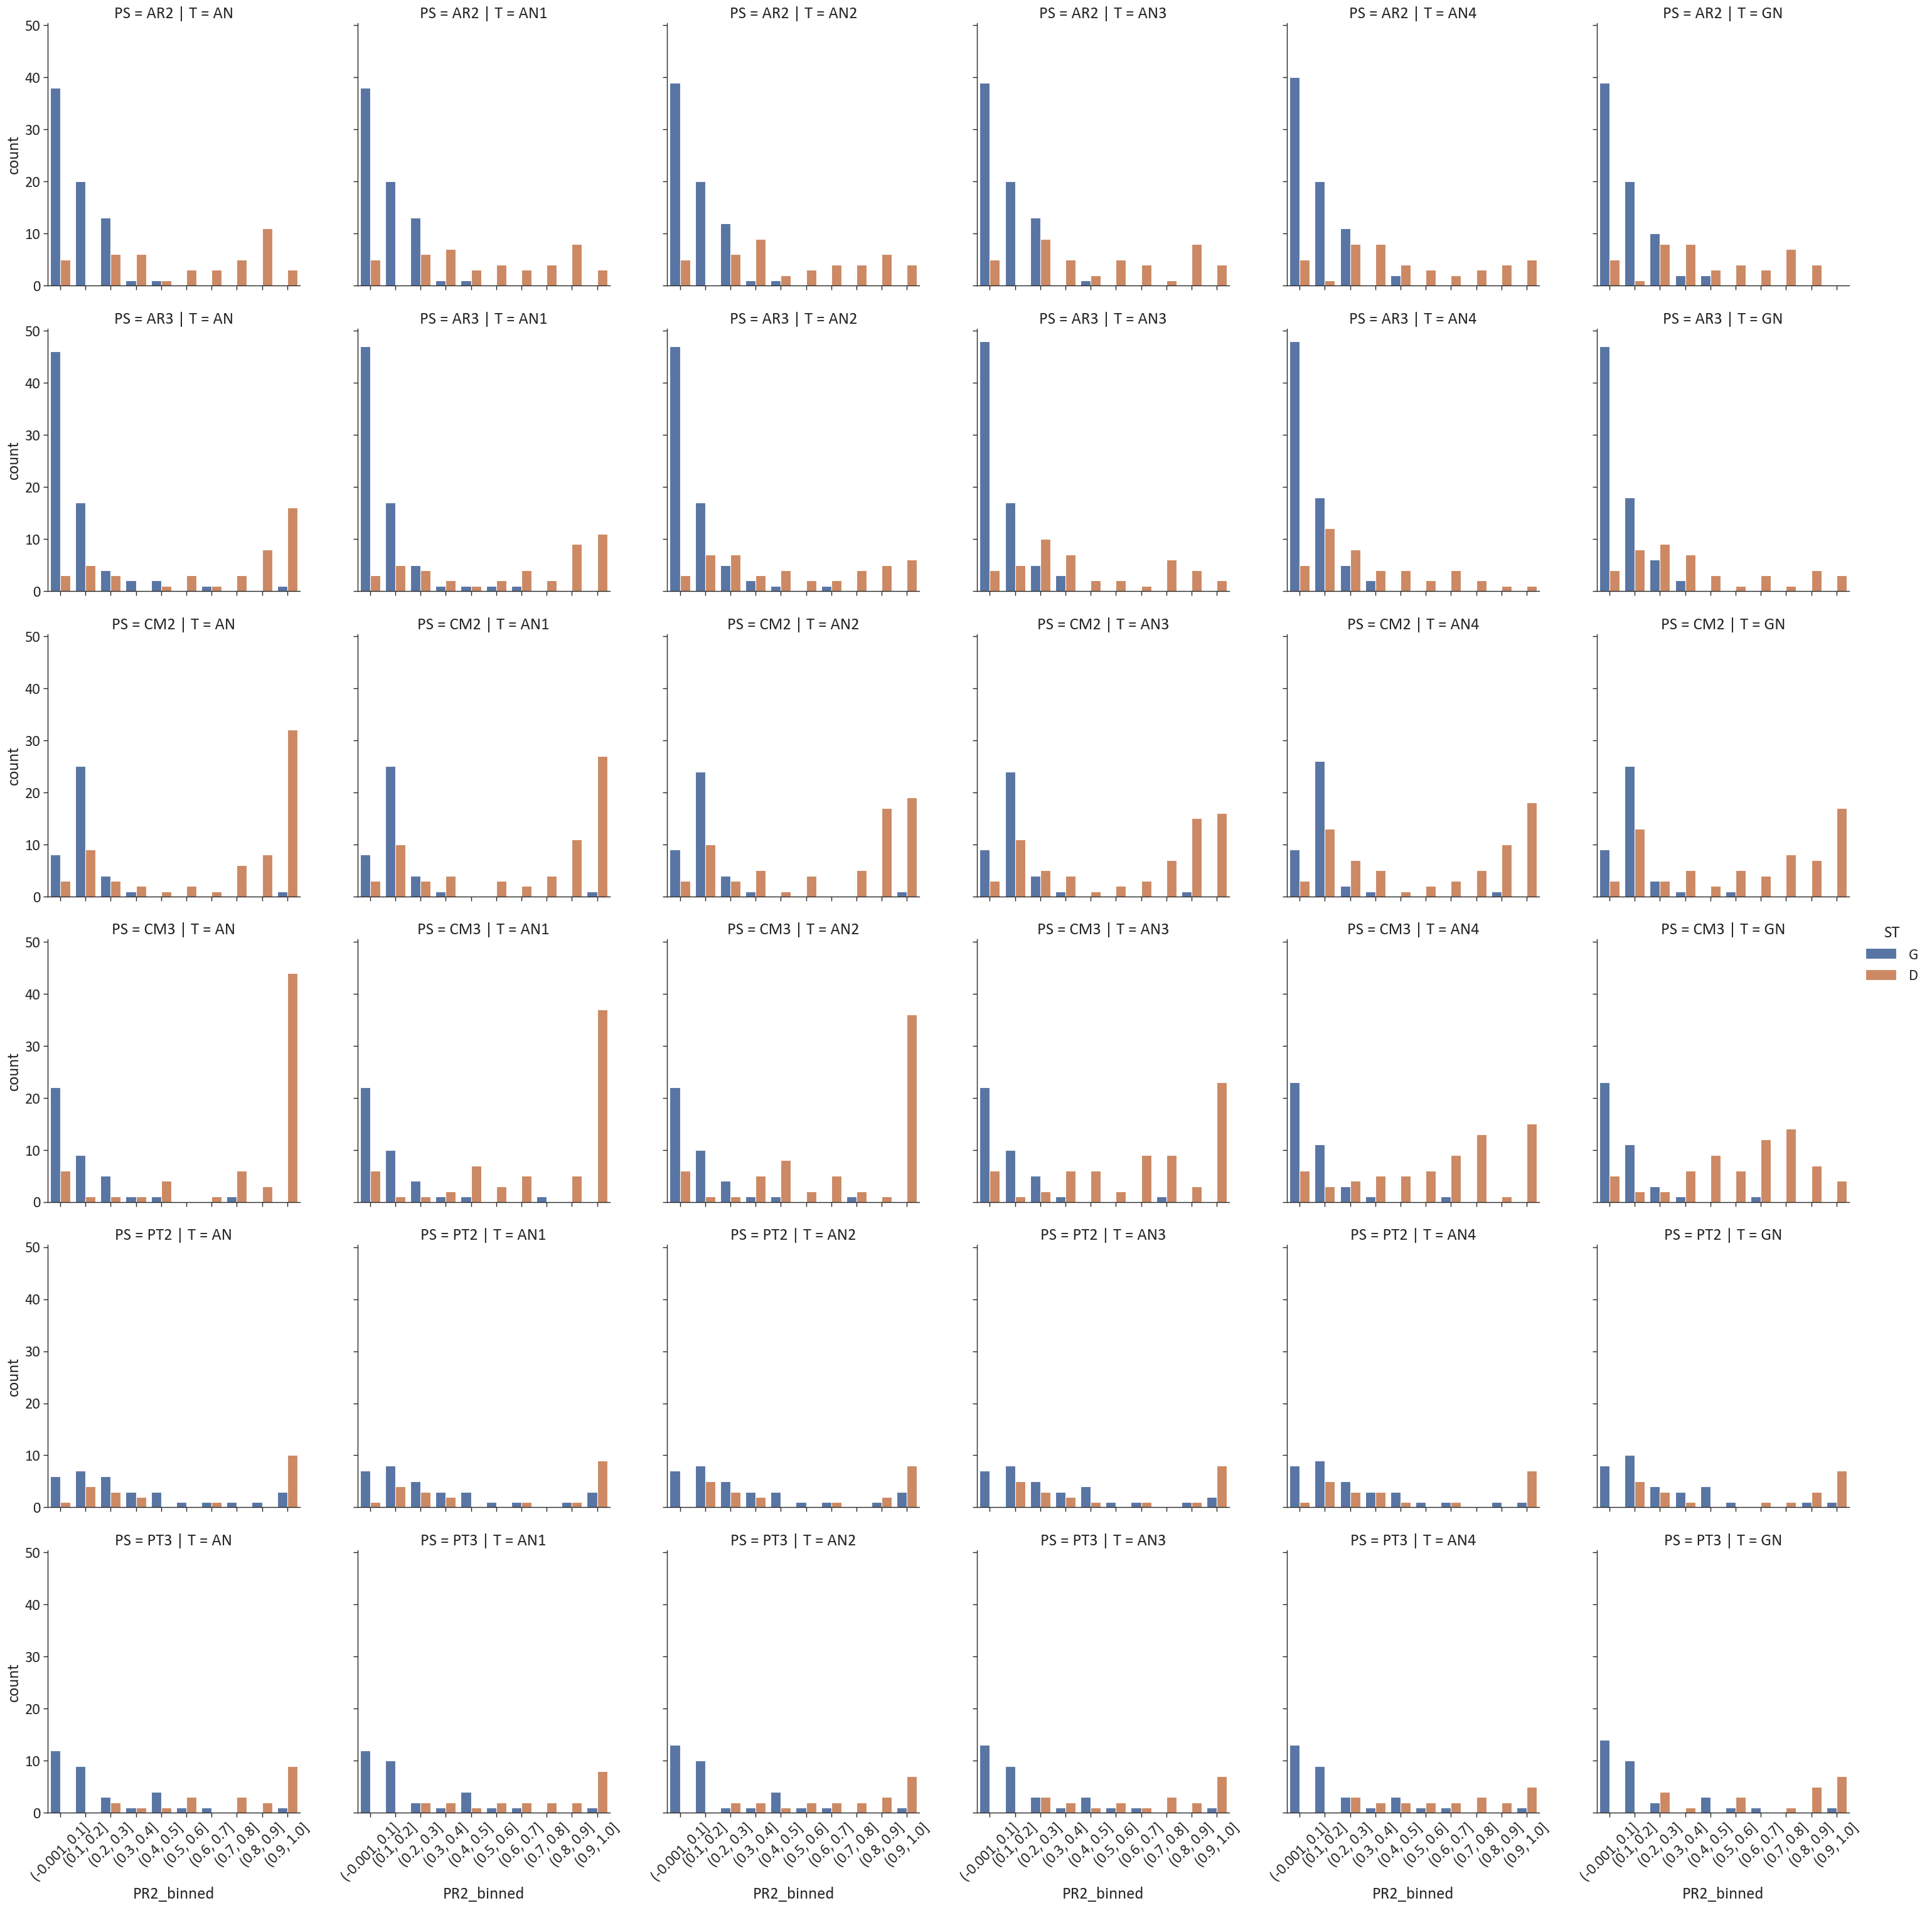

In [8]:
cp = sns.catplot(data=pred_data, x='PR2_binned', kind="count",
            col='T', row='PS',
           hue='ST')

loc, labels = plt.xticks()
cp.set_xticklabels(labels, rotation=45)
plt.show()

In [9]:
for st in ['D', 'G']:
    
    for ps in pred_data['PS'].unique():
    
        for t in TYPES:
    
            res = stats.kstest(pred_data[(pred_data['ST']==st) 
                                      & (pred_data['PS']==ps) 
                                      & (pred_data['T']==t)][to_test], 'norm') #p-value near zero rejects normality
            stat = res[0]
            p_v = res[1]
            #print(res)
            print(f'{st} - {ps} - {t: <3}: statistic: {stat:.3f} - p-value {p_v:.3f}')

D - AR2 - AN : statistic: 0.504 - p-value 0.000
D - AR2 - AN1: statistic: 0.504 - p-value 0.000
D - AR2 - AN2: statistic: 0.504 - p-value 0.000
D - AR2 - AN3: statistic: 0.504 - p-value 0.000
D - AR2 - AN4: statistic: 0.504 - p-value 0.000
D - AR2 - GN : statistic: 0.504 - p-value 0.000
D - AR3 - AN : statistic: 0.500 - p-value 0.000
D - AR3 - AN1: statistic: 0.500 - p-value 0.000
D - AR3 - AN2: statistic: 0.500 - p-value 0.000
D - AR3 - AN3: statistic: 0.500 - p-value 0.000
D - AR3 - AN4: statistic: 0.500 - p-value 0.000
D - AR3 - GN : statistic: 0.500 - p-value 0.000
D - CM2 - AN : statistic: 0.531 - p-value 0.000
D - CM2 - AN1: statistic: 0.531 - p-value 0.000
D - CM2 - AN2: statistic: 0.531 - p-value 0.000
D - CM2 - AN3: statistic: 0.531 - p-value 0.000
D - CM2 - AN4: statistic: 0.531 - p-value 0.000
D - CM2 - GN : statistic: 0.531 - p-value 0.000
D - CM3 - AN : statistic: 0.555 - p-value 0.000
D - CM3 - AN1: statistic: 0.525 - p-value 0.000
D - CM3 - AN2: statistic: 0.517 - p-valu

#### Significance

In [10]:
p_vals_dr = test_stat_sign(pred_data, to_test)

p_vals_dr_styled = p_vals_dr.style.set_table_styles(styles)\
        .format('{:.3f}')\
        .apply(lambda x: ["background:goldenrod" if v > 0.05 else "" for v in x], axis = 1)
p_vals_dr_styled

### Number of Recommended Courses #R

In [11]:
to_test = '#R'

#### Normality

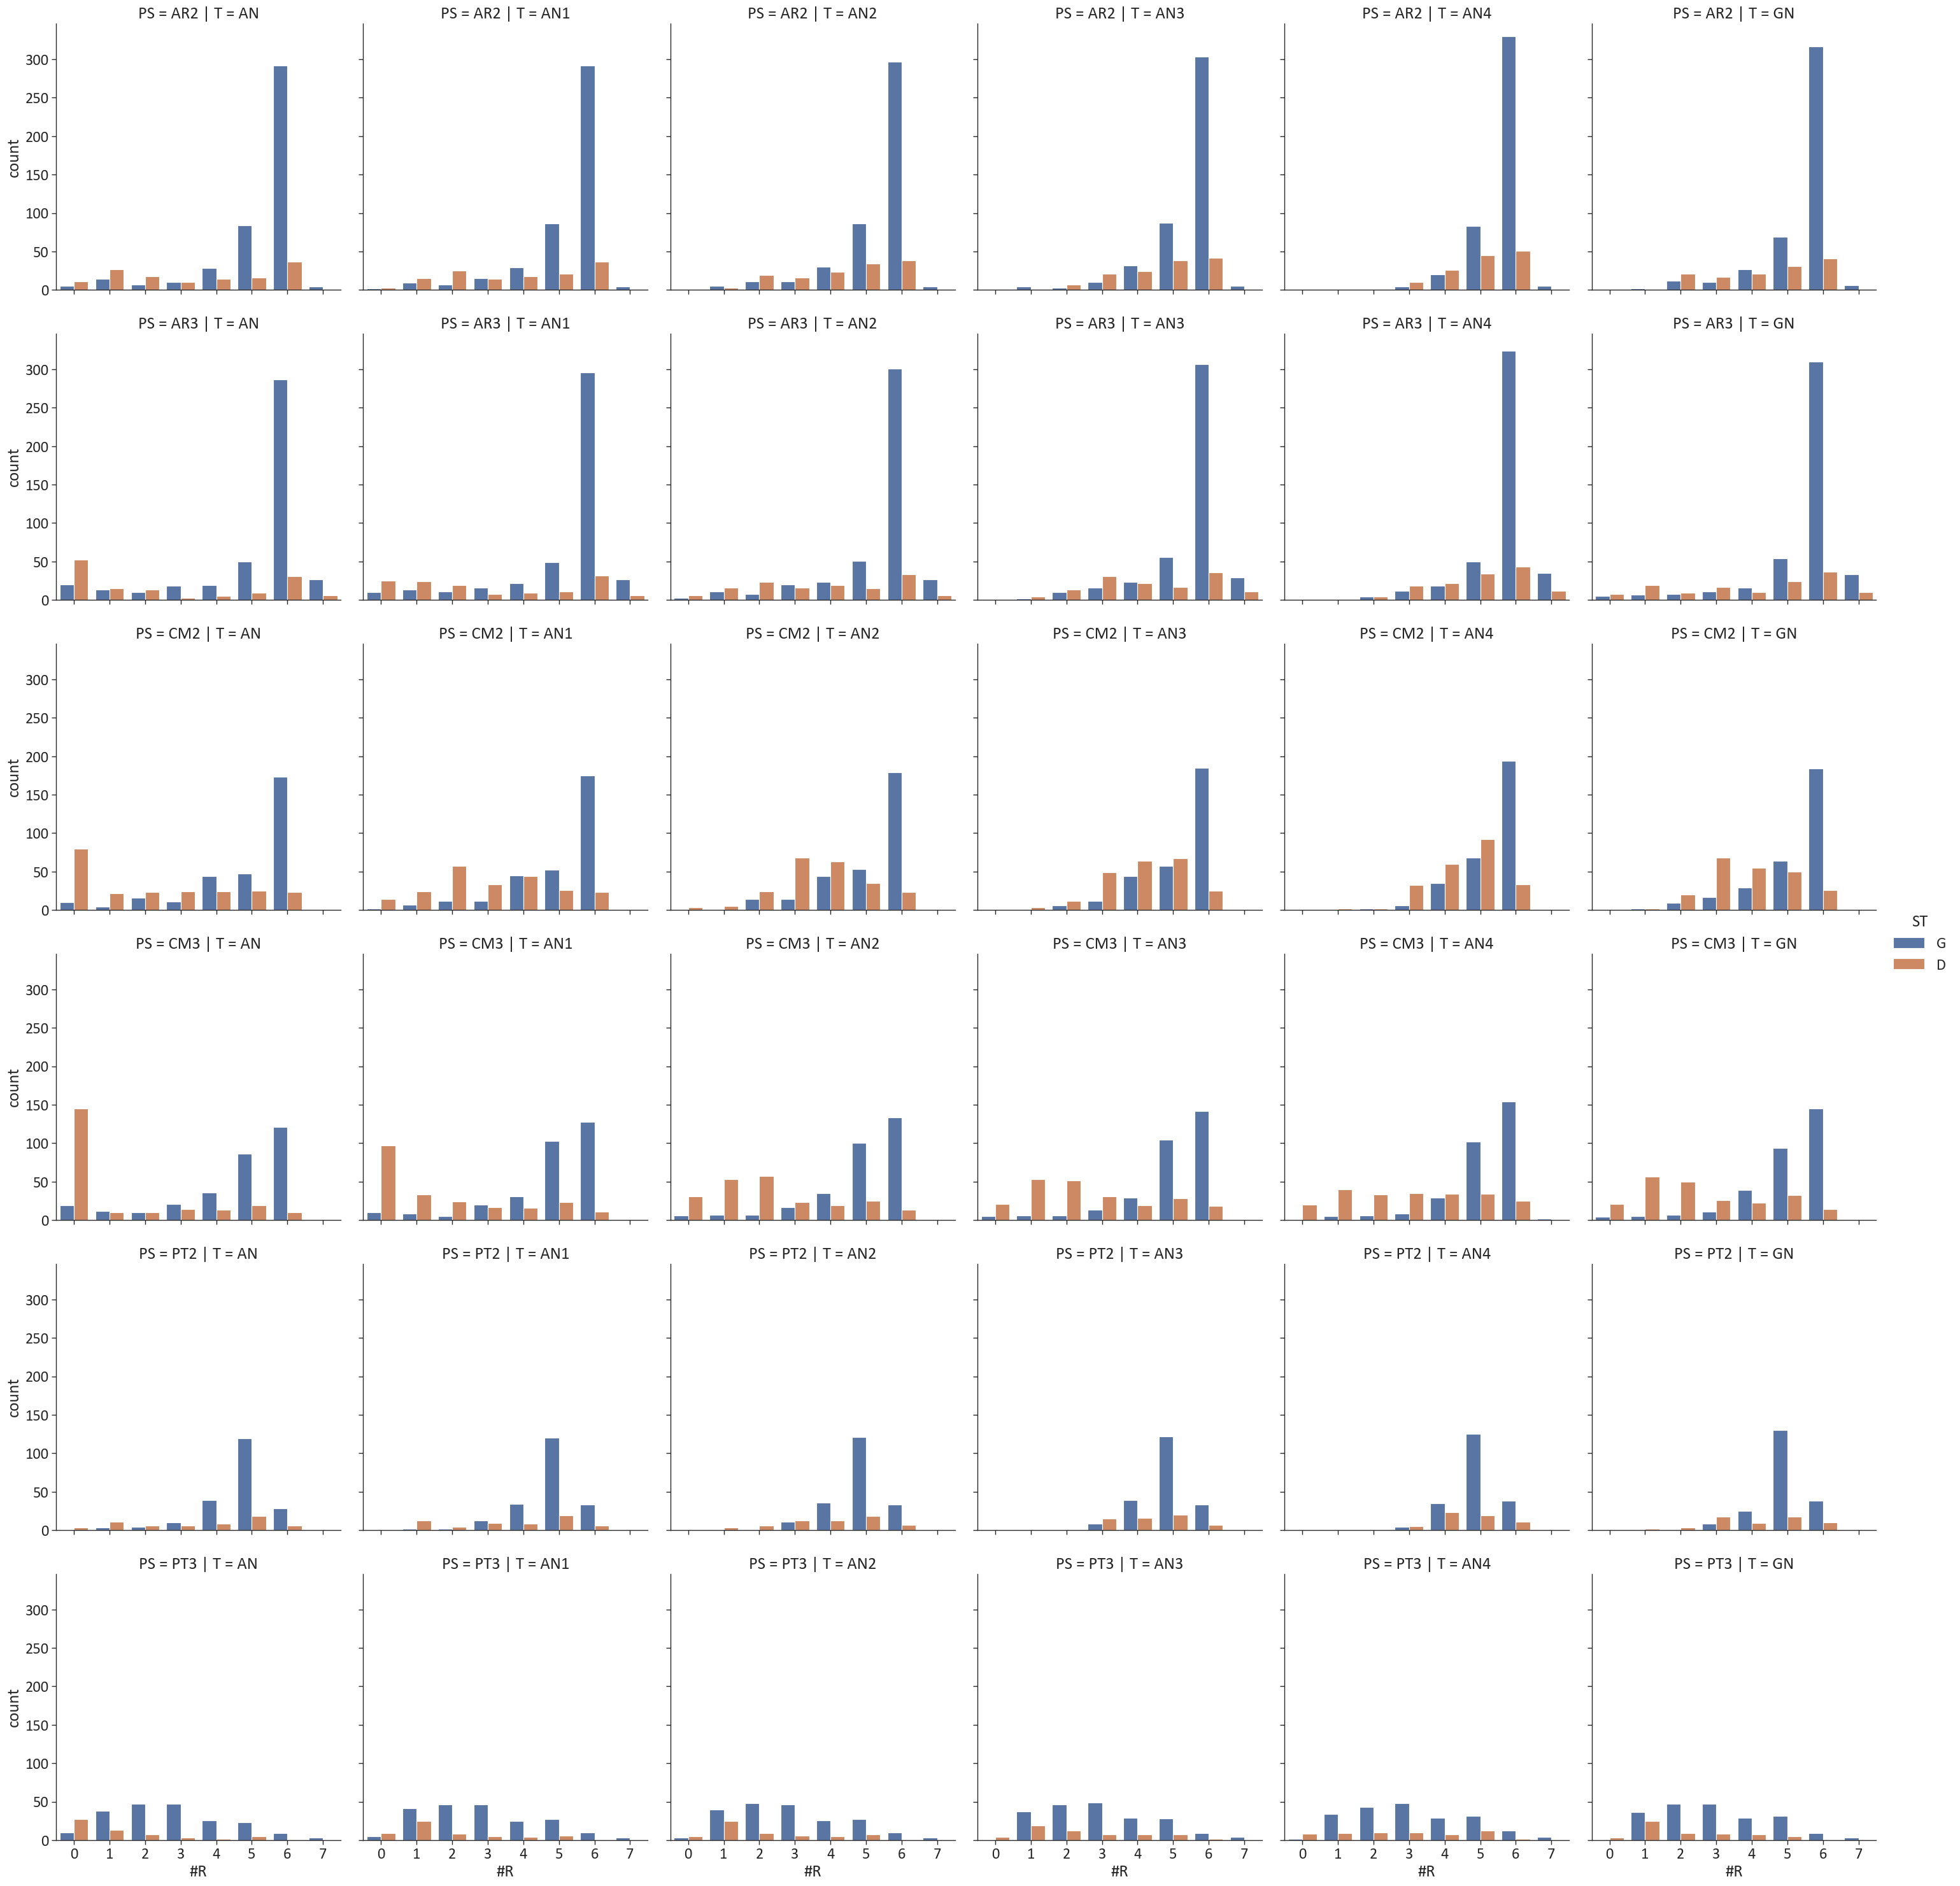

In [12]:
sns.catplot(data=recoms, x=to_test, kind="count",
            col='T', row='PS',
           hue='ST')
plt.show()

In [13]:
for st in ['D', 'G']:
    
    for ps in recoms['PS'].unique():
    
        for t in TYPES:
    
            res = stats.kstest(recoms[(recoms['ST']==st) 
                                      & (recoms['PS']==ps) 
                                      & (recoms['T']==t)][to_test], 'norm') #p-value near zero rejects normality
            stat = res[0]
            p_v = res[1]
            #print(res)
            print(f'{st} - {ps} - {t: <3}: statistic: {stat:.3f} - p-value {p_v:.3f}')

D - AR2 - AN : statistic: 0.759 - p-value 0.000
D - AR2 - AN1: statistic: 0.843 - p-value 0.000
D - AR2 - AN2: statistic: 0.955 - p-value 0.000
D - AR2 - AN3: statistic: 0.970 - p-value 0.000
D - AR2 - AN4: statistic: 0.991 - p-value 0.000
D - AR2 - GN : statistic: 0.962 - p-value 0.000
D - AR3 - AN : statistic: 0.500 - p-value 0.000
D - AR3 - AN1: statistic: 0.655 - p-value 0.000
D - AR3 - AN2: statistic: 0.813 - p-value 0.000
D - AR3 - AN3: statistic: 0.947 - p-value 0.000
D - AR3 - AN4: statistic: 0.970 - p-value 0.000
D - AR3 - GN : statistic: 0.782 - p-value 0.000
D - CM2 - AN : statistic: 0.516 - p-value 0.000
D - CM2 - AN1: statistic: 0.805 - p-value 0.000
D - CM2 - AN2: statistic: 0.941 - p-value 0.000
D - CM2 - AN3: statistic: 0.959 - p-value 0.000
D - CM2 - AN4: statistic: 0.981 - p-value 0.000
D - CM2 - GN : statistic: 0.968 - p-value 0.000
D - CM3 - AN : statistic: 0.500 - p-value 0.000
D - CM3 - AN1: statistic: 0.500 - p-value 0.000
D - CM3 - AN2: statistic: 0.701 - p-valu

#### Significance

In [14]:
p_vals_r = test_stat_sign(recoms, to_test)
p_vals_r_styled = p_vals_r.style.set_table_styles(styles)\
        .format('{:.3f}')\
        .apply(lambda x: ["background:goldenrod" if v > 0.05 else "" for v in x], axis = 1)
p_vals_r_styled

### Intersection

In [15]:
to_test = 'F1'

# just for the plot
recoms['F1_binned'] = pd.cut(recoms['F1'], 10) 
recoms[['F1','F1_binned']].sample(n=5,random_state=SEED)

,F1,F1_binned
8464,1.0,"(0.9, 1.0]"
7264,1.0,"(0.9, 1.0]"
9111,0.8,"(0.7, 0.8]"
1898,0.8,"(0.7, 0.8]"
1373,1.0,"(0.9, 1.0]"


#### Normality

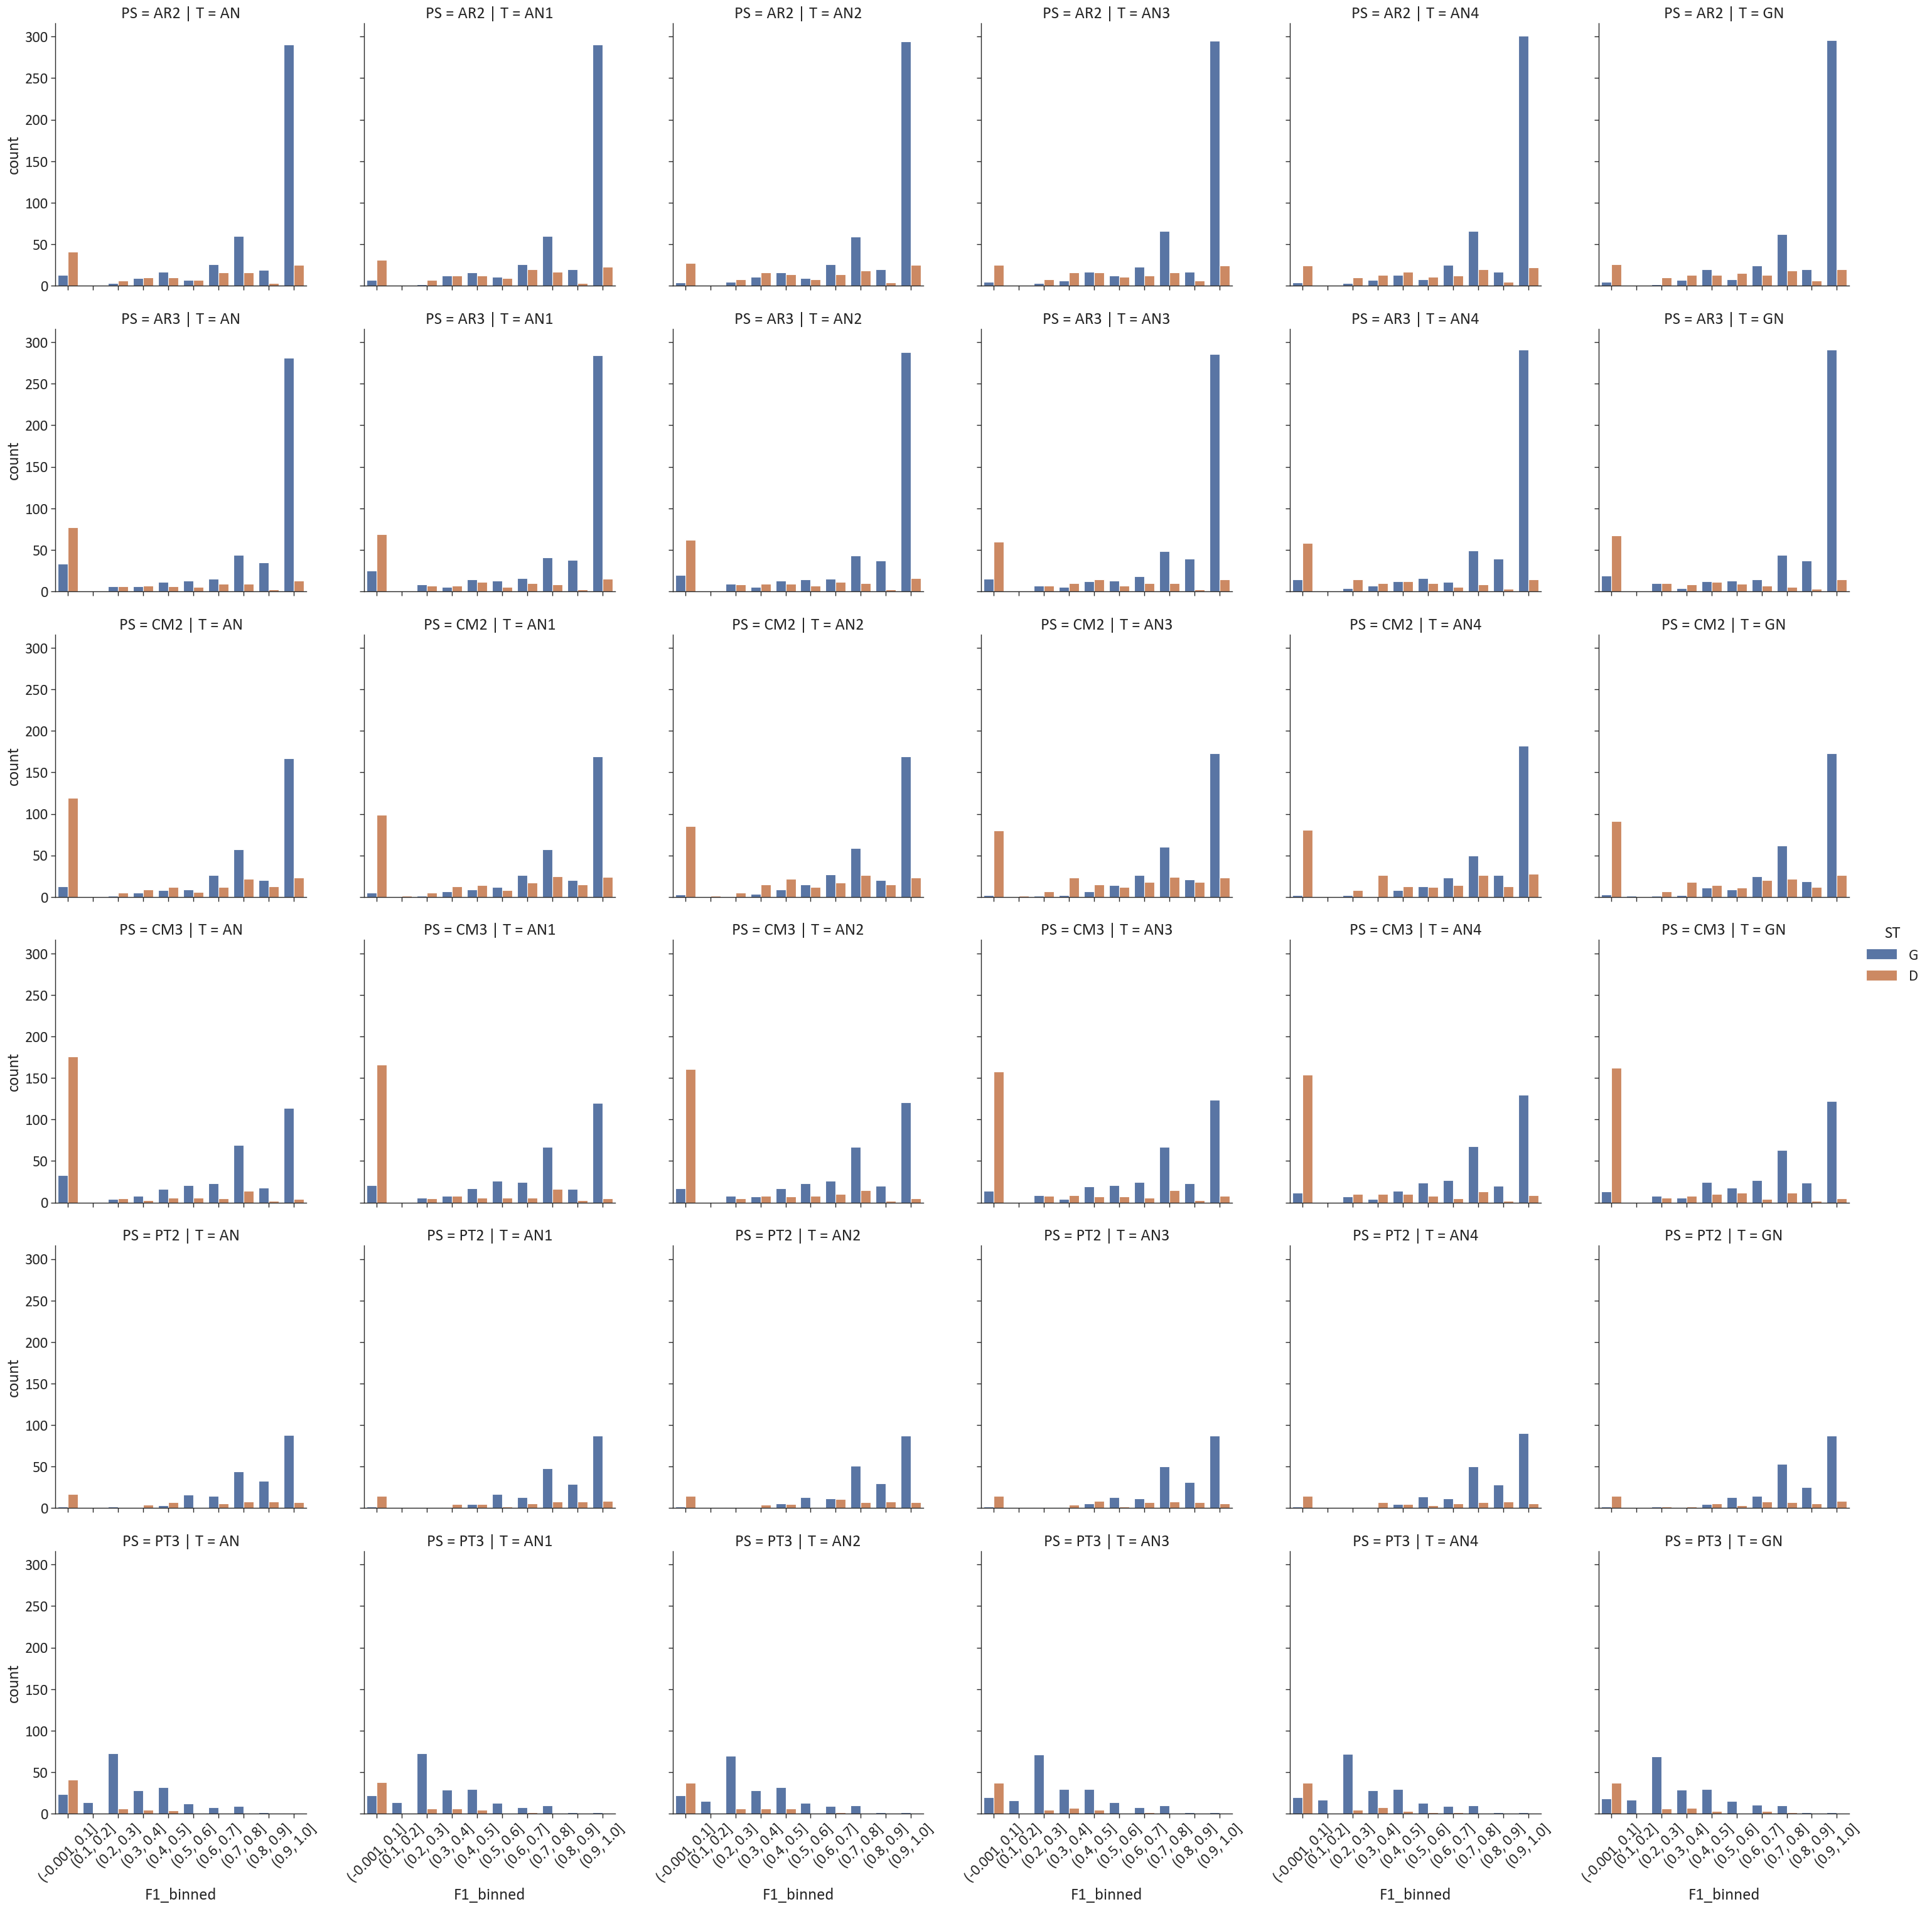

In [16]:
cp = sns.catplot(data=recoms,
                 x='F1_binned',
                 kind="count",
                 col='T',
                 row='PS',
                 hue='ST')

loc, labels = plt.xticks()
cp.set_xticklabels(labels, rotation=45)

plt.show()

In [17]:
for st in ['D', 'G']:
    
    for ps in recoms['PS'].unique():
    
        for t in TYPES:
    
            res = stats.kstest(recoms[(recoms['ST']==st) 
                                      & (recoms['PS']==ps) 
                                      & (recoms['T']==t)][to_test], 'norm') #p-value near zero rejects normality
            stat = res[0]
            p_v = res[1]
            #print(res)
            print(f'{st} - {ps} - {t: <3}: statistic: {stat:.3f} - p-value {p_v:.3f}')

D - AR2 - AN : statistic: 0.500 - p-value 0.000
D - AR2 - AN1: statistic: 0.500 - p-value 0.000
D - AR2 - AN2: statistic: 0.500 - p-value 0.000
D - AR2 - AN3: statistic: 0.500 - p-value 0.000
D - AR2 - AN4: statistic: 0.500 - p-value 0.000
D - AR2 - GN : statistic: 0.500 - p-value 0.000
D - AR3 - AN : statistic: 0.500 - p-value 0.000
D - AR3 - AN1: statistic: 0.500 - p-value 0.000
D - AR3 - AN2: statistic: 0.500 - p-value 0.000
D - AR3 - AN3: statistic: 0.500 - p-value 0.000
D - AR3 - AN4: statistic: 0.500 - p-value 0.000
D - AR3 - GN : statistic: 0.500 - p-value 0.000
D - CM2 - AN : statistic: 0.500 - p-value 0.000
D - CM2 - AN1: statistic: 0.500 - p-value 0.000
D - CM2 - AN2: statistic: 0.500 - p-value 0.000
D - CM2 - AN3: statistic: 0.500 - p-value 0.000
D - CM2 - AN4: statistic: 0.500 - p-value 0.000
D - CM2 - GN : statistic: 0.500 - p-value 0.000
D - CM3 - AN : statistic: 0.500 - p-value 0.000
D - CM3 - AN1: statistic: 0.500 - p-value 0.000
D - CM3 - AN2: statistic: 0.500 - p-valu

#### Significance

In [18]:
p_vals_f = test_stat_sign(recoms, to_test)
p_vals_f_styled = p_vals_f.style.set_table_styles(styles)\
        .format('{:.3f}')\
        .apply(lambda x: ["background:goldenrod" if v > 0.05 else "" for v in x], axis = 1)
p_vals_f_styled

#### Combine Results

In [20]:
p_vals_all = pd.concat([p_vals_dr, p_vals_f, p_vals_r], axis=1)

for t in {t[0] for t in p_vals_all.index}:
    
    for m in ['#R', 'F1', 'PR2']:
        
        count_t = 0
        count_t = p_vals_all.loc[(t),(m, 'Count')].sum().sum()

        p_vals_all.loc[(t, 'xAll'), (m, 'Count')] = count_t
        
for t in {t[0] for t in p_vals_all.index}:
    
    count_t = 0
    count_t = p_vals_all.loc[[i for i in p_vals_all.index if (i[0]==t) & (i[1] != 'xAll')],
                             (slice(None), 'Count')].sum().sum()
    
    p_vals_all.loc[(t, 'xAll'), ('Count')] = count_t
    
p_vals_all = p_vals_all.sort_index()
p_vals_all.index.set_levels([p_vals_all.index.get_level_values(0).unique(), 
                       p_vals_all.index.get_level_values(1).str.replace('xAll', 'All').unique()], inplace=True)

p_vals_all_styled = p_vals_all.style.set_table_styles(styles)\
    .format('{:.2f}')\
    .format('{:.0f}', subset=[c for c in p_vals_all.columns 
                              if (c[0] == 'Count') | (c[1] == 'Count')])\
    .apply(lambda x: ["background:goldenrod" if v >=0.05 else "" for v in x], 
           axis = 1, subset=[c for c in p_vals_all.columns if(c[0] != 'Count') & (c[1] != 'Count')])

p_vals_all_styled